In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/train.zip
/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/test.zip


In [2]:
#extracting all zipped files

import zipfile

with zipfile.ZipFile("/kaggle/input/denoising-dirty-documents/train.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/denoising-dirty-documents/test.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/denoising-dirty-documents/train_cleaned.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip","r") as z:
    z.extractall(".")

In [3]:
train_images_path = './train'
train_cleaned_path = './train_cleaned'
test_images_path  = './test'

train_images = sorted(os.listdir(train_images_path))
train_cleaned = sorted(os.listdir(train_cleaned_path))
test_images = sorted(os.listdir(test_images_path))

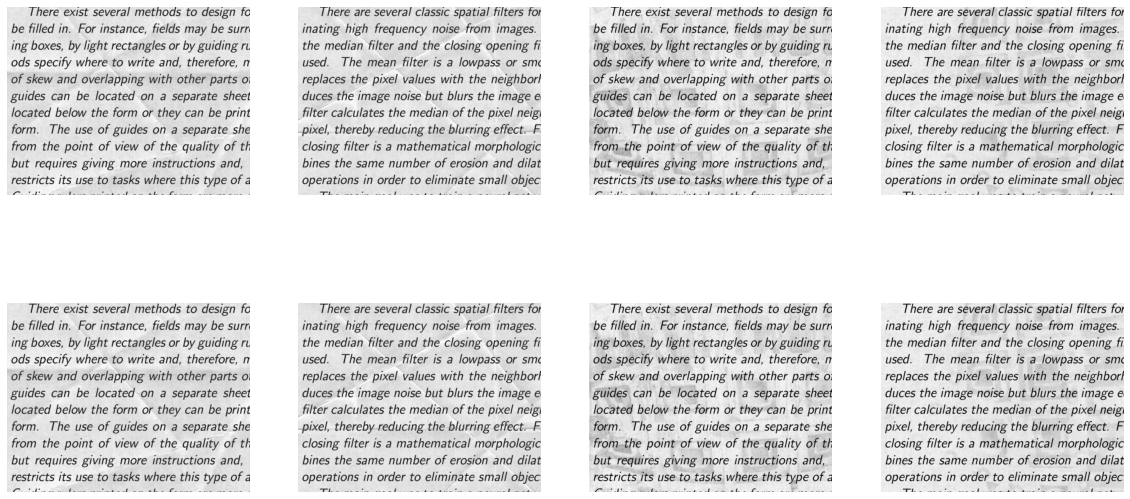

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
samples = train_images[:4] + train_cleaned[:4]

f, ax = plt.subplots(2, 4, figsize=(20,10))
for i, img in enumerate(samples):
    img = mpimg.imread(os.path.join(train_images_path, img))
    ax[i//4, i%4].imshow(img, cmap='gray')
    ax[i//4, i%4].axis('off')
plt.show()    

In [5]:
#load data into X and y arrays
from keras.preprocessing.image import load_img, img_to_array
X = []
y = []

for img in train_images:
    img_path = os.path.join(train_images_path, img)
    im = load_img(img_path, color_mode = 'grayscale', target_size = (540, 260))
    im = img_to_array(im).astype('float32')/255
    X.append(im)
for img in train_cleaned:
    img_path = os.path.join(train_cleaned_path, img)
    im = load_img(img_path, color_mode = 'grayscale', target_size = (540, 260))
    im = img_to_array(im).astype('float32')/255
    y.append(im)
    
X = np.array(X)
y = np.array(y)

print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

Using TensorFlow backend.


Shape of X:  (144, 540, 260, 1)
Shape of y:  (144, 540, 260, 1)


In [6]:
#split dataset into training and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = 42)

print('Number of training examples, ', X_train.shape[0])
print('Number of validation examples, ', X_valid.shape[0])
print(y_train.shape)
print(X_train.shape)

Number of training examples,  129
Number of validation examples,  15
(129, 540, 260, 1)
(129, 540, 260, 1)


In [7]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import Input
# create autoencoder model
def autoencoder():
    '''function to return an autoencoder model'''
    input_img = Input(shape=(540, 260, 1))
    #encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv_1')(input_img)
    x = MaxPooling2D((2, 2), padding='same', name = 'MaxPool_1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv_2')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name = 'MaxPool_2')(x)
    #decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv_3')(encoded)
    x = UpSampling2D((2, 2), name = 'UpSample_1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Conv_4')(x)
    x = UpSampling2D((2, 2), name = 'UpSample_2')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adamax', loss='binary_crossentropy')
    return autoencoder

In [8]:
#get model
autoencoder_model = autoencoder()
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 540, 260, 1)]     0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 540, 260, 64)      640       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 270, 130, 64)      0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 270, 130, 64)      36928     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 135, 65, 64)       0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 135, 65, 64)       36928     
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 270, 130, 64)      0     

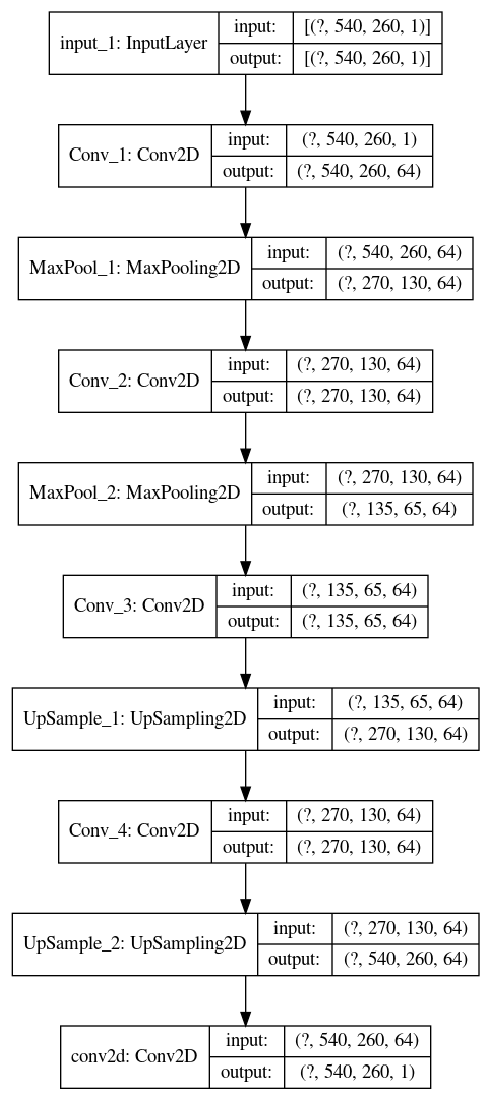

In [9]:
from keras.utils import plot_model
plot_model(autoencoder_model, to_file='autoencoder_model.png', show_layer_names = True,show_shapes = True, dpi = 96)
img = mpimg.imread('autoencoder_model.png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img, interpolation = 'nearest')

In [10]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min', restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [11]:
#fit model
history = autoencoder_model.fit(X_train, y_train, epochs = 200, batch_size = 8, validation_data = (X_valid, y_valid), verbose = True, callbacks = [es,rlr])

Epoch 1/200
17/17 [==============================] - 1s 86ms/step - loss: 0.4170 - val_loss: 0.3673 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 1s 57ms/step - loss: 0.3440 - val_loss: 0.3428 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 1s 56ms/step - loss: 0.3170 - val_loss: 0.3016 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 1s 57ms/step - loss: 0.2727 - val_loss: 0.2681 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 1s 56ms/step - loss: 0.2571 - val_loss: 0.2601 - lr: 0.0010
Epoch 6/200
17/17 [==============================] - 1s 60ms/step - loss: 0.2495 - val_loss: 0.2532 - lr: 0.0010
Epoch 7/200
17/17 [==============================] - 1s 56ms/step - loss: 0.2423 - val_loss: 0.2455 - lr: 0.0010
Epoch 8/200
17/17 [==============================] - 1s 56ms/step - loss: 0.2353 - val_loss: 0.2377 - lr: 0.0010
Epoch 9/200
17/17 [==============================] - 1s 56ms/step - loss: 0.2305 - val_loss: 0.2

In [12]:
def plot_loss(history, x = 'loss', y = 'val_loss'):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history[x])
    ax.plot(history.history[y])
    plt.title('Model Loss')
    plt.ylabel(y)
    plt.xlabel(x)
    plt.legend(['Train', 'Val'], loc='upper left')
    ax.grid(color='black')
    plt.show()

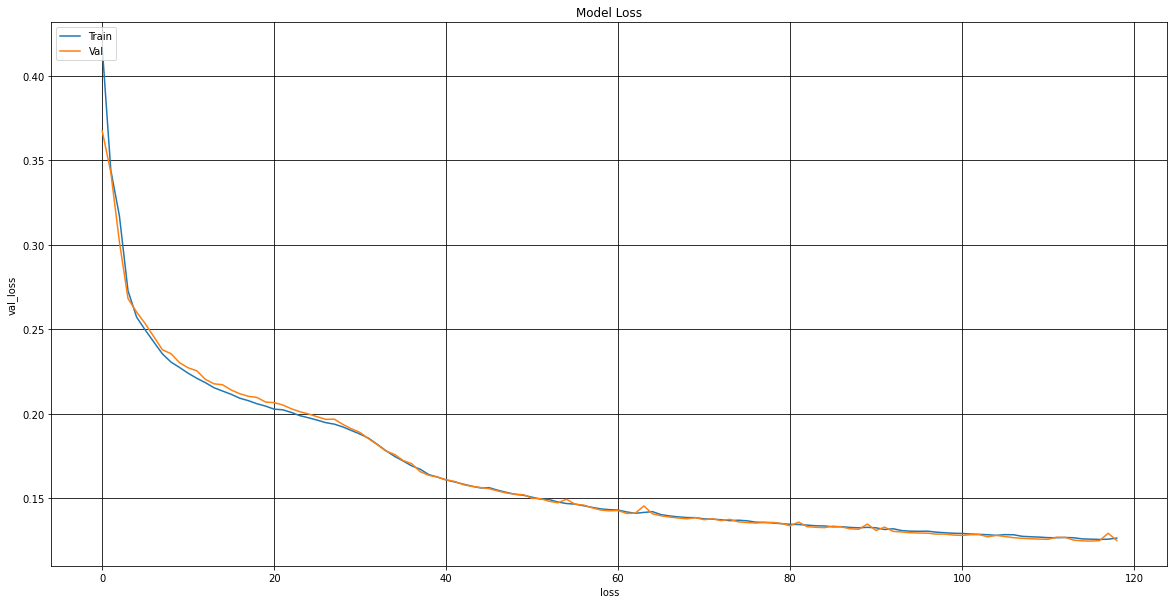

In [13]:
plot_loss(history)

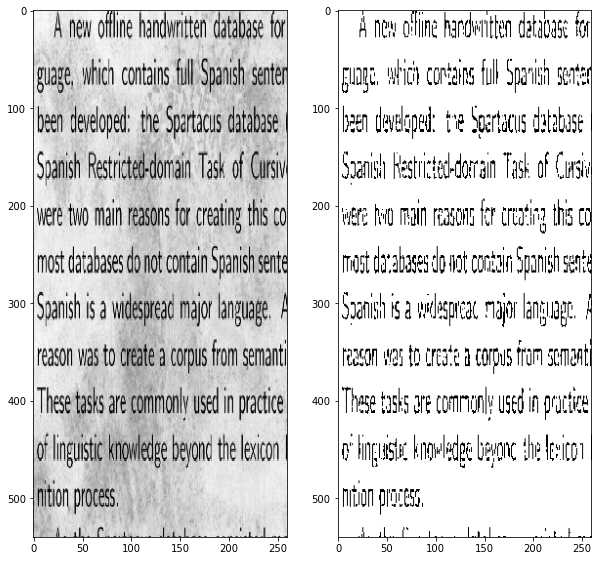

In [14]:
#viewing a sample from the test set and it's prediction
sample_test = load_img(os.path.join(test_images_path, test_images[7]), color_mode = 'grayscale', target_size=(540, 260))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder_model.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

In [15]:
X_test = []
for img in test_images:
    img_path = os.path.join(test_images_path, img)
    im = load_img(img_path, color_mode = 'grayscale', target_size = (540, 260))
    im = img_to_array(im).astype('float32')/255
    X_test.append(im)
    
X_test = np.array(X_test)

In [16]:
preds = autoencoder_model.predict(X_test)
print(preds.shape)

(72, 540, 260, 1)


In [17]:
import cv2
for img in preds:
    img = cv2.resize(img, (540, 258))

In [18]:
import glob
TEST_IMAGES = glob.glob('./test/*.png')
ids = []
vals = []
for i, f in enumerate(TEST_IMAGES):
    file = os.path.basename(f)
    imgid = int(file[:-4])
    test_img = cv2.imread(f, 0)
    img_shape = test_img.shape
    preds_reshaped = cv2.resize(preds[i], (img_shape[1], img_shape[0]))
    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

pd.DataFrame({'id': ids, 'value': vals}).to_csv('submission.csv', index=False)
